In [12]:
from datetime import datetime
import numpy as np
import torch
import torchvision
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
dataset = ImageFolder(root='/kaggle/input/assignment', transform=transform)

In [15]:
print("Number of images in the dataset:", len(dataset))
print("Number of classes in the dataset:", len(dataset.classes))

Number of images in the dataset: 30000
Number of classes in the dataset: 3


In [22]:
import torch.nn as nn

class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv8 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 3)

        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.pool3(x)
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool4(x)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))
        x = self.relu(self.conv13(x))
        x = self.pool5(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [17]:
def training(model,train_loader, val_loader, epochs = 20):
    print(f"run started at {str(datetime.now())}")
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    lossFunc = nn.CrossEntropyLoss()

    list_validation_loss = []
    list_training_loss = []
    list_train_acc = []
    list_valid_acc = []
    for epoch in range(epochs):
        train_loss=0
        train_acc=0
        val_loss=0
        val_acc=0
        model.train()
        for b_id,data in enumerate(train_loader):
            features,output = data
            features,output = features.to(device),output.to(device)
            optimizer.zero_grad()
            predictions = model(features)
            loss = lossFunc(predictions, output)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            train_acc += (predicted == output).float().sum().item()

        # Evaluate the model on the validation data
        model.eval()
        with torch.no_grad():
            for b_id, data in enumerate(val_loader):
                features,output = data
                features,output = features.to(device),output.to(device)
                predictions = model(features)
                loss = lossFunc(predictions, output)
                val_loss += loss.item()
                _, predicted = torch.max(predictions.data, 1)
                val_acc += (predicted == output).float().sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_valid_loss = val_loss/len(val_loader)
        epoch_valid_acc = val_acc/len(val_loader.dataset)
        
        list_validation_loss.append(epoch_valid_loss)
        list_training_loss.append(epoch_train_loss)
        list_train_acc.append(epoch_train_acc)
        list_valid_acc.append(epoch_valid_acc)
#         if (epoch+1)%10 ==0:
        print(f"{str(datetime.now())}")
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, epochs, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc))

    print(f"run ended at {str(datetime.now())}")
    return list_validation_loss,list_training_loss,list_train_acc,list_valid_acc

In [18]:
def testing(model, test_loader):
    model.eval()
    lossFunc = nn.CrossEntropyLoss()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            features,output = data
            features,output = features.to(device),output.to(device)
            predictions = model(features)
            loss = lossFunc(predictions, output)
            test_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            test_acc += (predicted == output).float().sum().item()
    
    final_test_loss = test_loss/len(test_loader)
    final_test_acc = test_acc/len(test_loader.dataset)
    print('Test Loss: {:.4f}, Test Acc: {:.4f}'.format(final_test_loss, final_test_acc))
    return final_test_loss, final_test_acc

In [19]:
def loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].plot(validation_loss,label = "Validation Loss")
    axs[0].plot(training_loss, label = "Training Loss")
    axs[0].set_title('Loss Graph for training and validation')
    axs[0].set_xlabel('Number Of Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(train_acc,label = "Training Accuracy")
    axs[1].plot(valid_acc,label = "Validation Accuracy")
    axs[1].set_title('Accuracy Graph for training and validation ')
    axs[1].set_xlabel('Number Of Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [20]:
# Split the dataset into 80% training data and 20% validation data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = val_dataset

# Create data loaders for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
model = VGGNet().to(device)
validation_loss,training_loss,train_acc,valid_acc = training(model,train_loader, val_loader, epochs = 20)

run started at 2023-04-13 19:01:06.411328
2023-04-13 19:12:01.139278
Epoch [1/20], Train Loss: 0.9368, Train Acc: 0.5863, Val Loss: 0.9071, Val Acc: 0.6350
2023-04-13 19:20:15.732857
Epoch [2/20], Train Loss: 0.8092, Train Acc: 0.7338, Val Loss: 0.7934, Val Acc: 0.7512
2023-04-13 19:28:26.886281
Epoch [3/20], Train Loss: 0.7493, Train Acc: 0.7972, Val Loss: 0.7333, Val Acc: 0.8132
2023-04-13 19:36:38.856846
Epoch [4/20], Train Loss: 0.7323, Train Acc: 0.8143, Val Loss: 0.7193, Val Acc: 0.8263
2023-04-13 19:44:51.009610
Epoch [5/20], Train Loss: 0.7160, Train Acc: 0.8313, Val Loss: 0.7333, Val Acc: 0.8097
2023-04-13 19:53:01.424279
Epoch [6/20], Train Loss: 0.7045, Train Acc: 0.8433, Val Loss: 0.6863, Val Acc: 0.8607
2023-04-13 20:01:13.938763
Epoch [7/20], Train Loss: 0.6950, Train Acc: 0.8530, Val Loss: 0.6786, Val Acc: 0.8697
2023-04-13 20:09:27.888586
Epoch [8/20], Train Loss: 0.6846, Train Acc: 0.8630, Val Loss: 0.6897, Val Acc: 0.8587
2023-04-13 20:17:38.821180
Epoch [9/20], Train

In [26]:
final_test_loss, final_test_acc = testing(model, test_loader)
Base_loss, Base_acc = final_test_loss, final_test_acc

# if Base_acc >= 0.9:
#     torch.save(model.state_dict(), 'weights.pt')

Test Loss: 0.6551, Test Acc: 0.8930


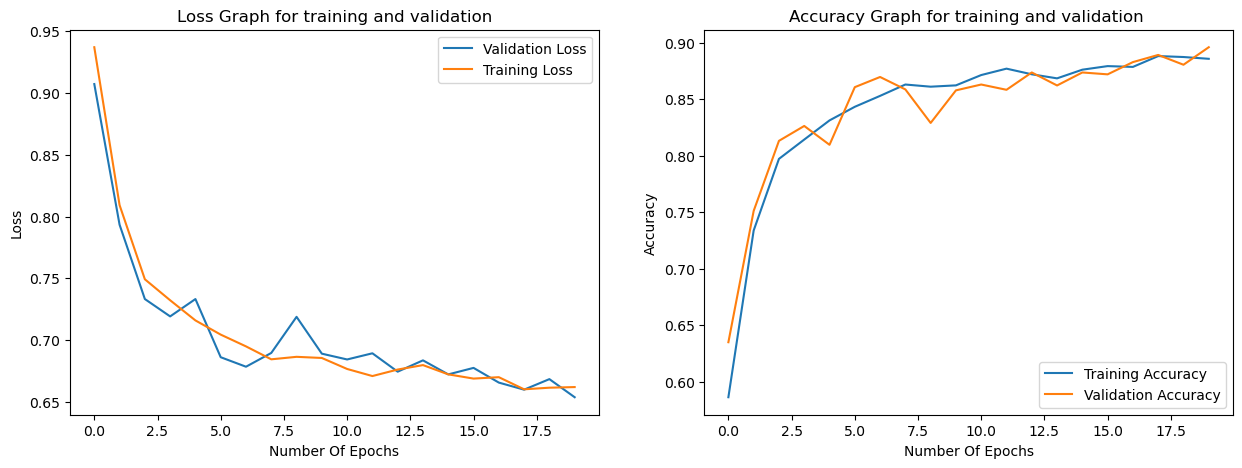

In [27]:
loss_acc_graphs(validation_loss,training_loss,train_acc,valid_acc) 

Reference
https://www.analyticsvidhya.com/blog/2021/06/build-vgg-net-from-scratch-with-python/